In [1]:
import sys, os, time
import shutil
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision

from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
# plt.switch_backend('Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from bisect import bisect_left

# from IPython.display import HTML, Image

#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

from tqdm import tqdm_notebook as tqdm

# plt.ioff()

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# dataset = train.get_dataset('nocap-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=True)
# len(dataset)

In [3]:
# dataset = train.get_dataset('transfer', new='nocap-3dshapes', budget=100,
#                             new_kwargs={'dataroot':os.environ['FOUNDATION_DATA_DIR'], 'labels':False})
# len(dataset)

In [9]:
# dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
#                            factor='shape', counts=[0,10,0,10])

# dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
#                            factor='shape', counts=[0, None, 0, 0])

dataset = train.get_dataset('transfer', dataroot=os.environ['FOUNDATION_DATA_DIR'], new='byfactor', old='byfactor', budget=100, old2new_ratio=1,
                             new_kwargs={
                                         'counts': [0, 100, 0, 0],
                                         'labels':False},
                             old_kwargs={
                                         'counts': [0, 0, None, 0],
                                        'labels':False})

len(dataset)

Filtering out 383900/384000 samples
Filtering out 287990/384000 samples


200

In [10]:
idx = np.random.randint(len(dataset), size=16)
idx

array([128, 199,  25, 146, 128,  64, 140,  78,  77, 118, 191, 137,  74,  82, 189, 155])

<IPython.core.display.Javascript object>


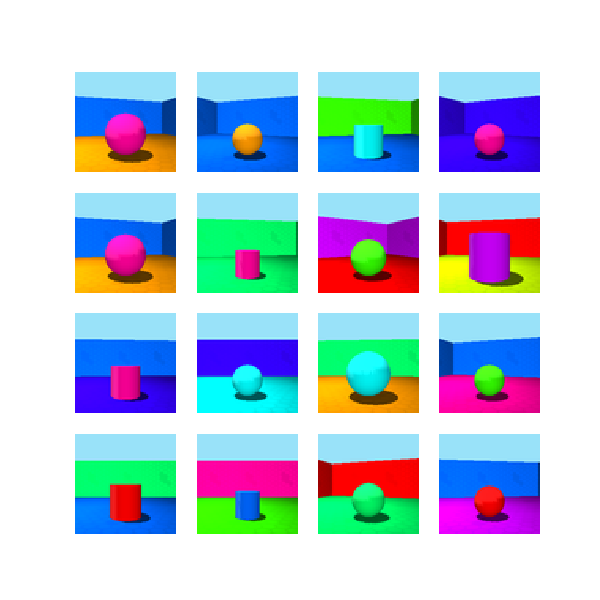

torch.Size([16, 3, 64, 64])


In [11]:
samples = [dataset[i] for i in idx]
if len(samples[0]) > 1:
    X, Y = zip(*samples)
    X = torch.stack(X)
    Y = torch.stack(Y)
else:
    X = torch.stack([s[0] for s in samples])
    Y = None
show_nums(X)
if Y is not None:
    print(Y.shape)
else:
    print(X.shape)

In [14]:
M = Hybrid_Controller().filter_strs('!test')

Found 268 runs


In [15]:
M.clear_run_cache()

In [16]:
M.clear_filters().filter_strs('!test')

# M.filter_datasets( 'redball', 'rgbball', '3dshapes')

# M.filter_since(date='200114').filter_data('rgbball')
# M.filter_jobs(157, 158)
# M.filter_jobs(169)
M.filter_jobs(178)
# M.filter_jobs(174, 175)
# M.filter_models('vae')
# M.filter_jobs(94, 122) # basic models
# M.filter_jobs(100, 102)
# M.filter(lambda r: 'adain-dec' in r.config.info.history)
# M.filter_models('wae')

# M.filter_checkpoints(60)

# M.load_configs(60)

# M.load_configs(100)

M.sort_by('job')
pass
M.show()


  0) cyl-wae_0178-6017981-00_200125-221552
  1) cyl-wae_0178-6017981-00_200125-221552_200126-191723
  2) cyl-wae_0178-6017981-00_200125-221552_200126-192006
  3) cyl-wae_0178-6017981-00_200125-221552_200126-192348
  4) cyl-wae_0178-6017981-02_200125-222200
  5) cyl-vae_0178-6017981-03_200125-222128
  6) cyl-vae_0178-6017981-04_200125-222245
  7) cyl-fwae_0178-6017981-05_200125-222334
  8) cyl-fwae_0178-6017981-06_200125-222430
  9) cyl-fvae_0178-6017981-07_200125-222631


In [17]:
# M.prep_info(100)
M.prep_info()

Selecting checkpoint: last
cyl-wae_0178-6017981-00_200125-221552_200126-191723 has no checkpoint
cyl-wae_0178-6017981-00_200125-221552_200126-192006 has no checkpoint
cyl-wae_0178-6017981-00_200125-221552_200126-192348 has no checkpoint


/is/ei/fleeb/workspace/foundation/foundation/train/config.py:80: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


Loaded configs


In [18]:
M.show('all')

  0) cyl-wae_0178-6017981-00_200125-221552
	Checkpoint: 406
	auto_name - True (_)
	dataset.batch_size - 128 (_)
	dataset.counts - [0, 0, -1, 0] (_)
	dataset.drop_last - False (_)
	dataset.factor - shape (_)
	dataset.kwargs.counts - [0, 0, -1, 0] (_)
	dataset.kwargs.factor - shape (_)
	dataset.name - byfactor (_)
	dataset.shuffle - True (_)
	dataset.val_split - 0.1 (_)
	device - cuda (_)
	model._type - wpp (_)
	model.beta1 - 0.9 (_)
	model.beta2 - 0.999 (_)
	model.channels - [64, 64, 64, 128, 128] (_)
	model.criterion.name - bce (_)
	model.criterion.reduction - sum (_)
	model.disc_steps - 5 (_)
	model.discriminator._type - double-enc (_)
	model.discriminator.beta1 - 0.5 (_)
	model.discriminator.beta2 - 0.9 (_)
	model.discriminator.dout - 1 (_)
	model.discriminator.fc - [256, 128, 64] (_)
	model.discriminator.latent_dim - 1 (_)
	model.discriminator.tail._type - nn (_)
	model.discriminator.tail.din - [128, 2, 2] (_)
	model.discriminator.tail.dout - 1 (_)
	model.discriminator.tail.hidden_d

In [20]:
print('\n'.join(M.through().name))

cyl-wae_0178-6017981-00_200125-221552
cyl-wae_0178-6017981-02_200125-222200
cyl-vae_0178-6017981-03_200125-222128
cyl-vae_0178-6017981-04_200125-222245
cyl-fwae_0178-6017981-05_200125-222334
cyl-fwae_0178-6017981-06_200125-222430
cyl-fvae_0178-6017981-07_200125-222631


In [27]:
run = M[0]
run.name

'cyl-wae_0178-6017981-00_200125-221552'

In [28]:
S = run.reset()

In [29]:

S.dataset = dataset
len(S.dataset)

200

In [30]:
# S.A = train.get_config()
# S.A.dataset.kwargs = {'counts': [0, 128, 128, 0]}
# S.A.dataset.val_split = '__x__'

S.A.skip_precomputed = True
# S.A.use_train = True


# S.A.device = 'cpu'

KeyError: 'A'

In [10]:
# S.bounds = -2,2
run.load(pbar=tqdm)

/is/ei/fleeb/workspace/chome/trained_nets/cyl-wae_0178-6017981-00_200125-221552/checkpoint_397.pth.tar
True
load successful
Loaded /is/ei/fleeb/workspace/chome/trained_nets/cyl-wae_0178-6017981-00_200125-221552/checkpoint_397.pth.tar
Set dataroot to: /is/ei/fleeb/workspace/local_data
name: byfactor
Filtering out 383744/384000 samples
Dataset byfactor moved to cpu
Dataset din=(3, 64, 64), dout=(3, 64, 64)
Model-type: wpp
encoder (type=double-enc): 
  in_shape --> din: (3, 64, 64) (by parent)
  channels: [64, 64, 64, 128, 128] (by parent)
  factors: 2 (by parent)
  internal_channels: [None, None, None, None, None] (by default)
  squeeze: [False, False, False, False, False] (by default)
  output_nonlin: None (by default)
  latent_dim: 12 (by parent)
  tail (type=nn): 
    input_dim --> din: (128, 2, 2)
    output_dim --> dout: 12
    hidden_dims: [256, 128]
    nonlin: elu (by parent)
    output_nonlin: None (by default)
  nonlin: elu (by parent)
  output_nonlin: None (by default)
  outpu

In [11]:
run.run(pbar=tqdm)

Using batched data loader
No validation set found


In [12]:
plt.ioff()
viz = run.visualize(tqdm)
len(viz), viz.keys()

(7,
 dict_keys(['original', 'recs', 'gens', 'hybrid', 'latent', 'effects', 'traversals']))

<IPython.core.display.Javascript object>


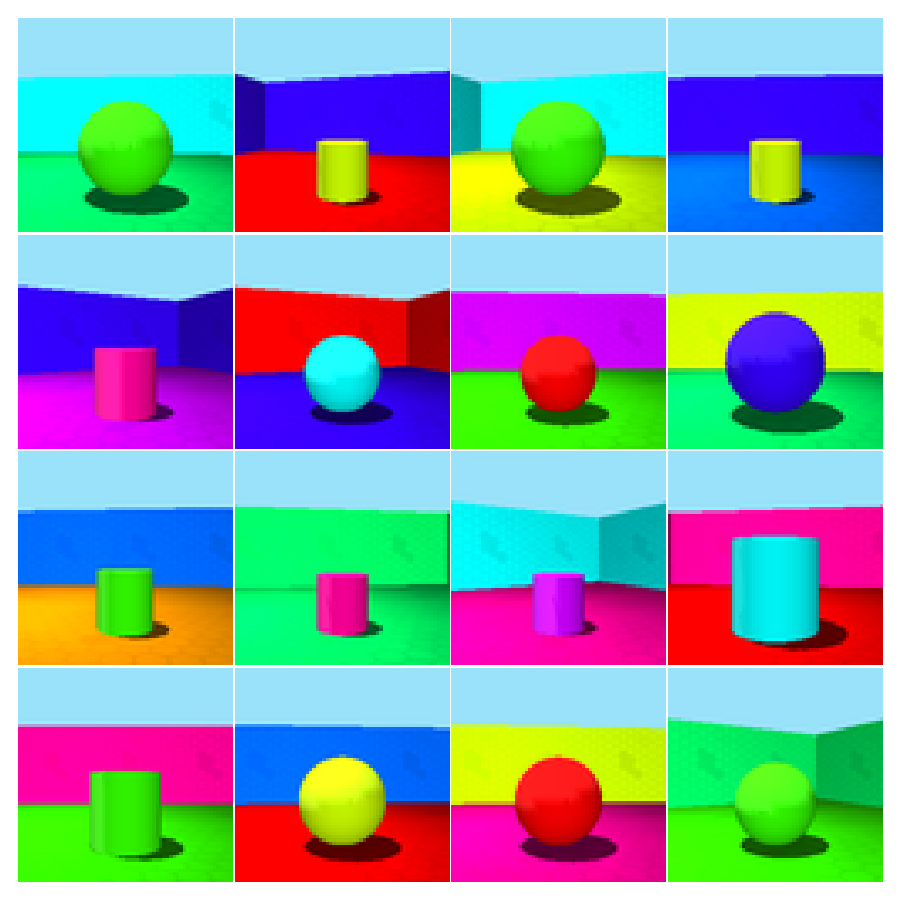

In [15]:
viz['original'][0].view(scale=2)

<IPython.core.display.Javascript object>


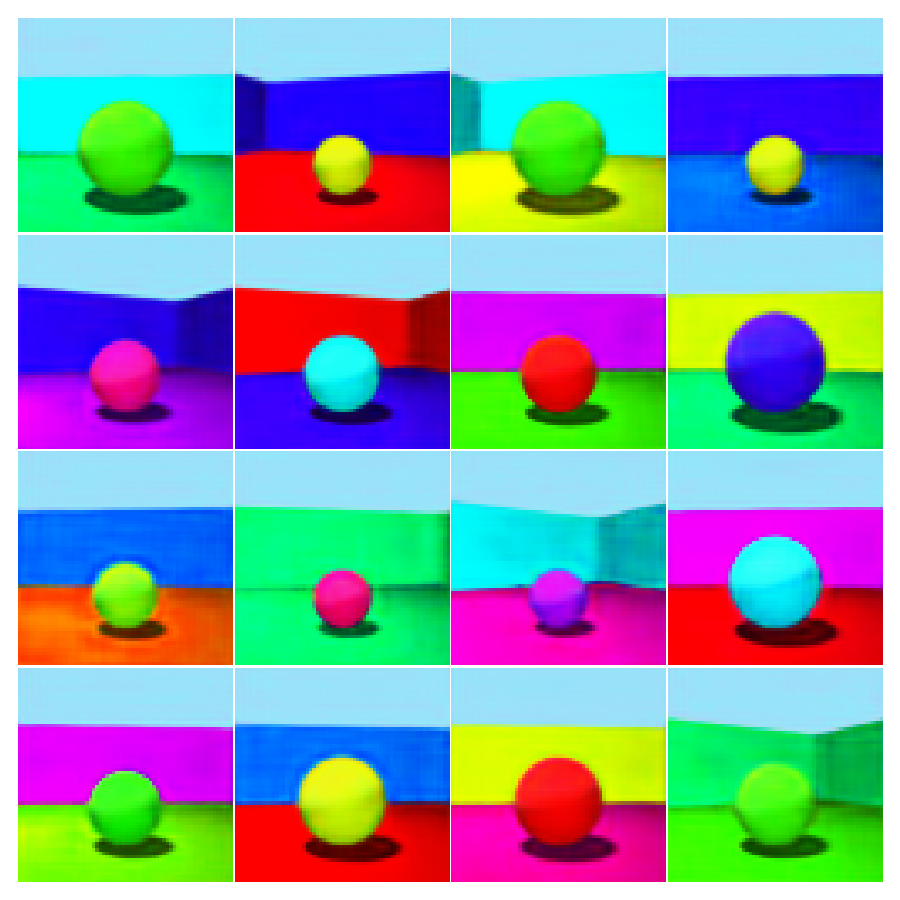

In [14]:
viz['recs'][0].view(scale=2)

In [43]:
A = S.A

In [44]:
model = S.model

In [45]:
dataset = S.dataset
len(dataset)

256

In [46]:
# loader = train.get_loaders(dataset, batch_size=16, num_workers=A.num_workers,
# 	                           shuffle=True, drop_last=False, )

Using batched data loader
